## OASIS - Demonstration notebook - Choice set generation
*V1.0.0 September 2023*

This notebook walks through the parameter estimation module of OASIS. The estimator takes as input a scehedule, travel times and settings for the Metropolis-Hastings random walk. A set of unchosen schedules is generated, and formatted to be used as input for [Biogeme](http://biogeme.epfl.ch) (dataset in wide format).

You can find the full documentation [here](https://oasis-abm.readthedocs.io/en/latest/), and companion paper [here](https://doi.org/10.1016/j.trc.2023.104291).


### Main files

The following files are used for the simulation.

- ``estimation.py``: This script stores information on the ``ChoiceSetGenerator`` class, used to run the Metropolis-Hastings algorithm, and transform the generated choice set into the appropriate format. 
- ``metropolis_hastings.py``: Stores the ``random_walk`` function, as well as other functions to handle the results (convergence assessement, statistics)
- ``activity.py``: This script handles the input data, and creates ``Activity`` and ``Schedule`` objects. These objects contain information on each activity and on the structure of the schedule. They will be modified during the generation process.
- ``operator.py``: The ``Operator`` class and subclasses (e.g. ``Assign``) is used to handle the random walk operators, including functions to compute the change probabilities.
- ``runner.py``: The main file to run the simulation.

In addition, we have provided a small example to illustrate the implemented functions. They are stored in the ``data/`` folder.

In this notebook, we will generate a choice set for one individual.

In [1]:
import joblib
import pandas as pd
import numpy as np

import sys
sys.path.append('estimation/')

from estimation import ChoiceSetGenerator
from helper_func import parse_df_schedule, schedule_to_pandas


### Preparing the input

There are three main inputs that must be provided for the simulation: 

- The list of schedules, one schedule per individual in the population (``DATA``)
- A mode travel time matrix (``TT``)
- The set of activity parameters for the target distribution (``PARAMS``)



In [2]:
DATA = joblib.load('../data/example_data_estimation.joblib')
TT = joblib.load('../data/example_tt.joblib')

PARAMS = '../data/target_params.joblib'

Let's examine ``DATA``. 

This schedule contains two *work* activities and a *leisure* activities. The set of activities is provided as a ``pandas DataFrame``, and contains the label of the activities (a unique identifier and the activity type), a feasible start and end time (not mandatory, and will default to the full day if not provided), the location of the activity, the mode of transportation and desired start and end times. Note that the location and mode should exist as keys in the travel time matrix.

Contrary to the ``simulation`` module, the schedule should be an **observed** schedule, meaning that the columns ``start_time`` and ``duration`` must exist and indicate the actual start time and duration of each activity. 

In [3]:
DATA

,act_id,act_label,label,feasible_start,feasible_end,location,mode_travel,group,desired_start,desired_duration,start_time,end_time,duration
0,1.0,home,dawn,0,24,A,driving,dawn,0.000000,12.940332,0.000000,9.500000,9.500000
1,2.0,work,work1,5,23,B,driving,work,6.602686,10.470977,9.533333,13.500000,3.966667
2,1.0,home,home,0,24,A,driving,home,0.000000,12.940332,13.533333,15.166667,1.633333
3,2.0,work,work2,5,23,B,driving,work,6.602686,10.470977,15.200000,20.000000,4.800000
4,8.0,leisure,leisure,0,24,B,driving,leisure,16.005231,3.380537,20.466667,20.466667,0.000000
5,1.0,home,dusk,0,24,A,driving,dusk,0.000000,12.940332,20.500000,24.000000,3.500000


The travel time matrix is a dictionary formatted as:

``{mode: {
origin_location: {
destination_location1 : travel_time_1,
destination_location2 : travel_time_2
}}}``

The travel time is in hours. In this example, we consider the travel times for the *driving* mode and two different locations.



In [4]:
TT

{'driving': {'A': {'A': 0, 'B': 0.0002777777777777778},
  'B': {'A': 0.0002777777777777778, 'B': 0}}}

To proceed with the estimation, we transform the ``DataFrame`` schedule into a ``Schedule`` object. We can do this using the ``parse_df_schedule`` function. The ``Schedule`` class stores information on the activities in the schedule, which are themselves ``Activity`` objects (storing timings, locations, modes), as well as specific functions that will be helpful during the random walk. For example, the ``streamline()`` function makes sure to restore validity conditions (e.g. 24h time budget, start and end at home) after a change has been applied by an operator.

In [5]:
DATA = [parse_df_schedule(DATA, TT)]

In [6]:
print(type(DATA[0]))

<class 'activity.Schedule'>


In [7]:
for activity in DATA[0].list_act:
    print(activity)

home: start time 0.0, duration 9.5 h, location A
work: start time 9.533333333333331, duration 3.966666666666667 h, location B
home: start time 13.533333333333331, duration 1.6333333333333329 h, location A
work: start time 15.2, duration 4.800000000000001 h, location B
leisure: start time 20.466666666666665, duration 0.0 h, location B
home: start time 20.5, duration 3.5 h, location A


### Setting up the estimator

We create a new ``ChoiceSetGenerator``, to generate a choice set of ``n_alt = 5`` alternatives. We specify additional parameters for the Metropolis-Hastings algorithm, such as the number of iterations, the number of iterations for warm-up, and thinning. Note that these parameters can also be provided directly in the ``settings.py`` file. This file includes for example default parameters for operators and activities (probabilities).

In [34]:
mh_params = {"n_iter":1000,
"n_burn": 50,
 "n_skip": 1,
 "uniform": False,
}


In [35]:
estimator = ChoiceSetGenerator(DATA, PARAMS, n_alt = 5, mh_params=mh_params)

### Running and handling results

The ``run()`` function is called to run the Metropolis-Hastings algorithm. For large samples and number of iterations, we recommend parallelising the code using the ``run_parallel()``function instead.

We plot a few draws using the ``output`` function with the ``plot`` argument. Note that for each choice set, the first schedule is the chosen one.

In [36]:
estimator.run()

Starting generation for individual 0.



/Users/janodypougala/Desktop/PHD/OASIS/oasis_dev/estimation/metropolis_hastings.py:74: RuntimeWarning: divide by zero encountered in log
  ratio = min(np.log(abs(new_weight)) - np.log(abs(current_weight)) + np.log(b_proba) - np.log(f_proba), 0)
/Users/janodypougala/Desktop/PHD/OASIS/oasis_dev/estimation/metropolis_hastings.py:74: RuntimeWarning: invalid value encountered in log
  ratio = min(np.log(abs(new_weight)) - np.log(abs(current_weight)) + np.log(b_proba) - np.log(f_proba), 0)


Total runtime: 0:00:00.480029


In [39]:
unique_draws =[[item for idx, item in enumerate(choice_set) if item not in choice_set[:idx]] for choice_set in estimator.choice_sets]

len(unique_draws[0])

19

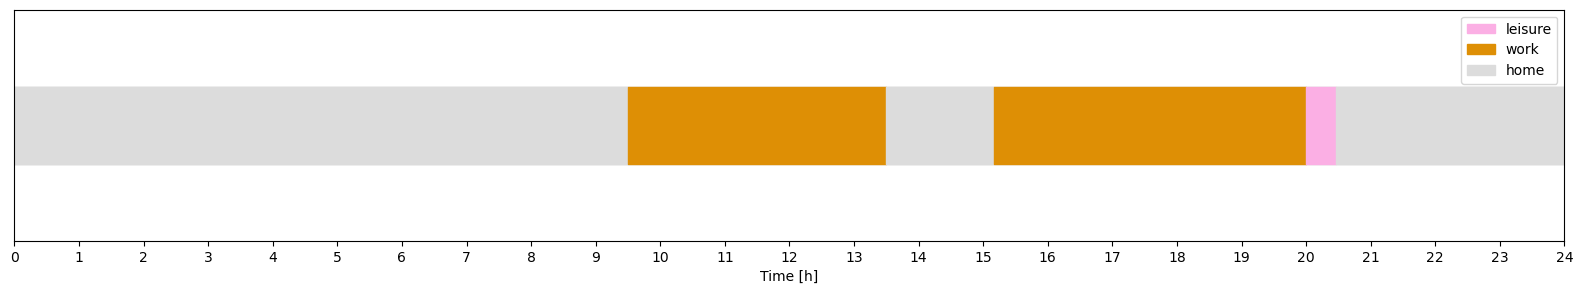

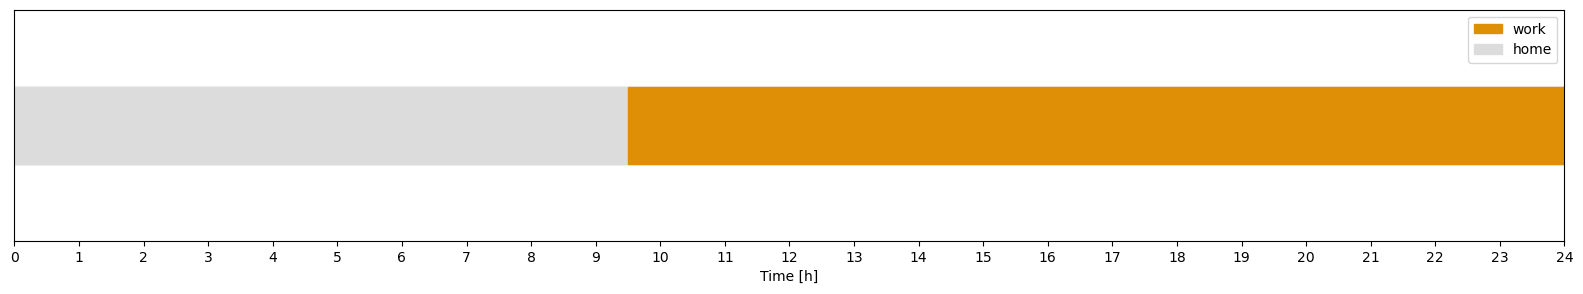

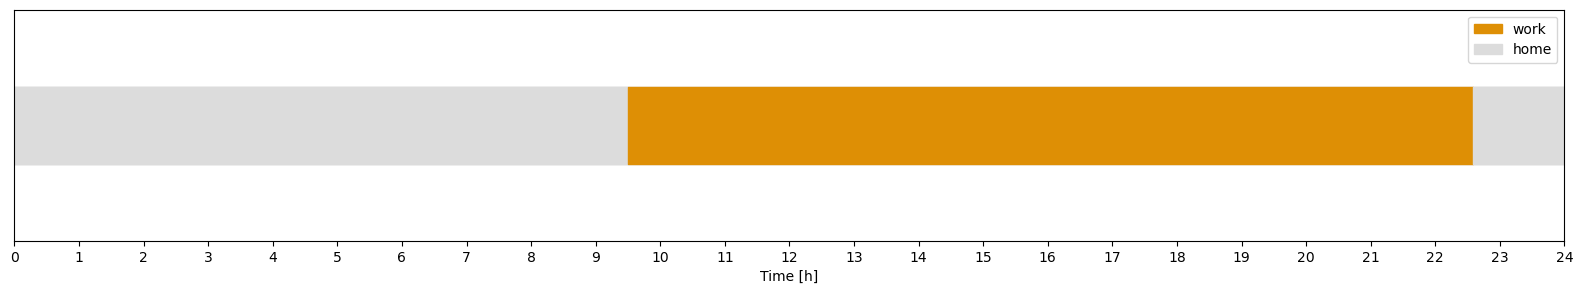

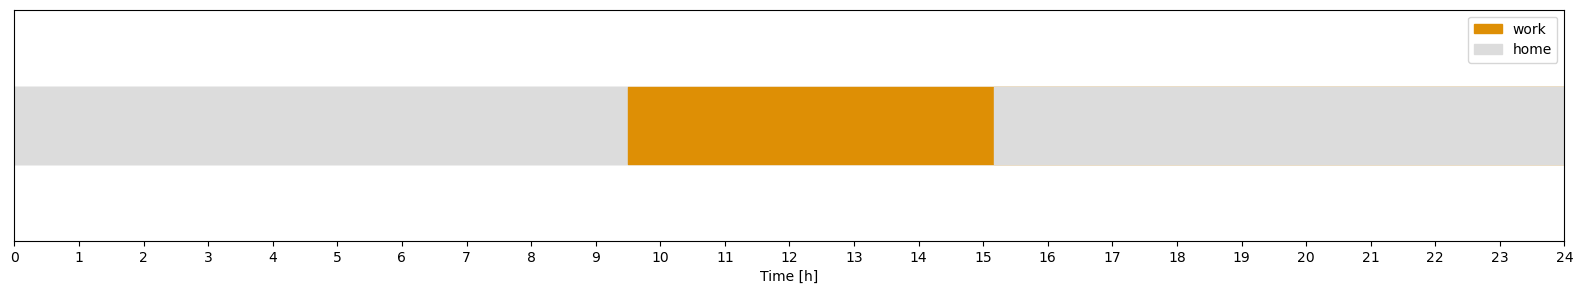

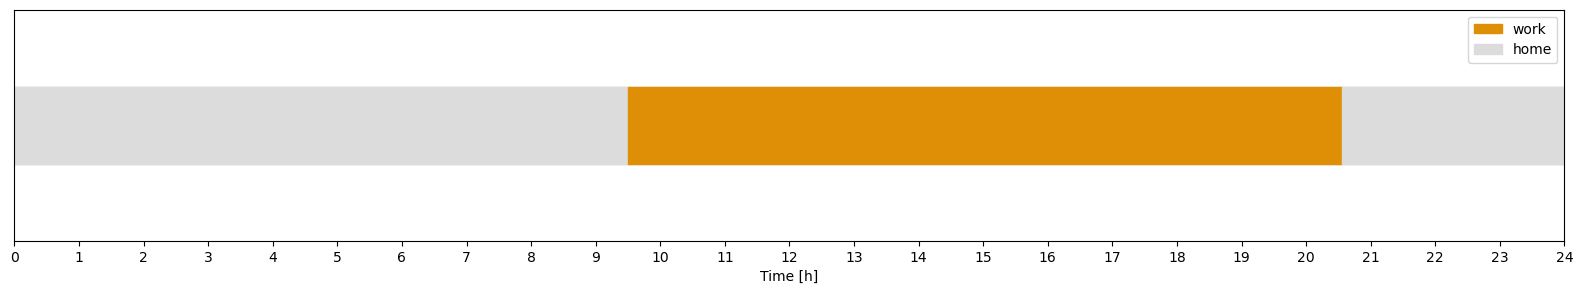

In [42]:
for c in unique_draws[0][:5]:
    c.output(plot=True)

We can use the function ``train_test_sets()`` to create train and test datasets for the estimation. By default, this function splits the observations to have 70% of individuals in the train set and 30% for testing. This function also computes the sample probability to correct the choice probabilities and likelihood function (see Ben-Akiva & Lerman, 1985):

$$P_{in} = P_n(i | \hat{C}_n) =  \frac{e^{\mu V_{in} + \mathbf{\ln P_n(\hat{C}_n | i)}}}{\sum_{j\in \hat{C}_n} e^{\mu V_{jn} + \mathbf{\ln P_n(\hat{C}_n | j)}}}$$

In [45]:
train_wide, train_long, test = estimator.train_test_sets()

In [46]:
train_long

,obs_id,alt_id,choice,prob_corr,home:start_time,home:duration,home:participation,work:start_time,work:duration,work:participation,...,business_trip:short,business_trip:long,leisure:early,leisure:late,leisure:short,leisure:long,escort:early,escort:late,escort:short,escort:long
0,0,0,1.0,868.954605,0.0,14.699444,1,9.500278,8.832778,1,...,0.0,0.0,0.000000,8.0,0.533333,0.000000,0.0,0.0,0.0,0.0
1,0,0,1.0,868.954605,0.0,14.699444,1,9.500278,8.832778,1,...,0.0,0.0,0.000000,8.0,0.533333,0.000000,0.0,0.0,0.0,0.0
2,0,1,1.0,870.149372,0.0,8.936165,1,8.659382,15.063280,1,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0,2,1.0,870.753124,0.0,8.659104,1,8.659382,3.299849,1,...,0.0,0.0,0.040491,0.0,0.000000,11.263152,0.0,0.0,0.0,0.0
4,0,3,1.0,869.954605,0.0,9.500000,1,9.500278,14.499722,1,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
5,0,4,1.0,870.272664,0.0,8.659104,1,8.659382,15.340618,1,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


In [48]:
train_wide

,obs_id,choice,prob_corr_0,home:start_time_0,home:duration_0,home:participation_0,work:start_time_0,work:duration_0,work:participation_0,education:start_time_0,...,business_trip:short_4,business_trip:long_4,leisure:early_4,leisure:late_4,leisure:short_4,leisure:long_4,escort:early_4,escort:late_4,escort:short_4,escort:long_4
0,0,0,868.954605,0.0,14.699444,1,9.500278,8.832778,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,868.954605,0.0,14.699444,1,9.500278,8.832778,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
joblib.dump(estimator, 'estimator_example.joblib')

['estimator_example.joblib']